In [1]:
# !mkdir -p /tmp/pip/cache/
# !cp ../input/segmentation-models-zip-003/efficientnet_pytorch-0.4.0.xyz /tmp/pip/cache/efficientnet_pytorch-0.4.0.tar.gz
# !cp ../input/segmentation-models-zip-003/pretrainedmodels-0.7.4.xyz /tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz
# !cp ../input/segmentation-models-zip-003/segmentation_models_pytorch-0.0.3.xyz /tmp/pip/cache/segmentation_models_pytorch-0.0.3.tar.gz

In [2]:
# !pip install --no-index --find-links /tmp/pip/cache/ efficientnet-pytorch > /dev/null
# !pip install --no-index --find-links /tmp/pip/cache/ segmentation-models-pytorch > /dev/null

In [1]:
import pdb
import os
import cv2
import time
import random
from glob import glob
import torch
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from collections import defaultdict
from torch.utils.data import DataLoader
import albumentations
from albumentations.pytorch import ToTensorV2 as ToTensor
import torch.utils.data as data
import segmentation_models_pytorch as smp
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250,60,20)]
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [3]:
class TestDataset(data.Dataset):
    def __init__(self, root, df, size, mean, std, tta=4, labels=None):
        self.root = root
        self.size = size
        df['ImageId'] = df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
        self.fnames = df['ImageId'].unique().tolist()
        if labels is not None:
            self.fnames = [self.fnames[x] for x in np.where(labels)[0]]
        self.num_samples = len(self.fnames)
        self.tta = tta
        self.TTA = albumentations.Compose(
            [
                albumentations.Rotate(limit=180, p=0.5),
                albumentations.Transpose(p=0.5),
                albumentations.Flip(p=0.5),
                #albumentations.RandomScale(scale_limit=0.1),
                albumentations.ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=120,
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),

            ]
        )
        self.transform = albumentations.Compose(
            [
                albumentations.Normalize(mean=mean, std=std, p=1),
                albumentations.Resize(size[0], size[1]),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname)
        image = cv2.imread(path)

        images = [self.transform(image=image)["image"]]
        for _ in range(self.tta):  # perform ttas
            aug_img = self.TTA(image=image)["image"]
            aug_img = self.transform(image=aug_img)["image"]
            images.append(aug_img)
        return fname, torch.stack(images, dim=0)

    def __len__(self):
        return self.num_samples

In [4]:
def post_process(probability, threshold, min_size):
    if probability.shape != (256, 1600):
        probability = cv2.resize(probability, (1600, 256)) # w, h
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


## Classifier

In [5]:
def get_predictions(model, testset, tta):
    """return all predictions on testset in a list"""
    num_images = len(testset)
    predictions = []
    for i, batch in enumerate(tqdm(testset)):
        if tta:
            for images in batch:  # images.shape [n, 3, 96, 96] where n is num of 1+tta
                preds = torch.sigmoid(model(images.to(device))) # [n, num_classes]
                preds = preds.mean(dim=0).detach().tolist()
                predictions.append(preds)
        else:
            fnames, images = batch
#             pdb.set_trace()
            preds = torch.sigmoid(model(images[:, 0].to(device)))
            preds = preds.detach().tolist() #[1]
            predictions.extend(preds)

    return np.array(predictions)


def efficientNet(name, out_features):
    '''name like: `efficientnet-b5`
    [2]
    '''

    model = EfficientNet.from_name(name)

    in_features = model._fc.in_features
    model._fc = torch.nn.Linear(in_features=in_features, out_features=out_features, bias=True)

    return model


In [6]:
# sample_submission_path = "../input/severstal-steel-defect-detection/sample_submission.csv"
# root = "../input/severstal-steel-defect-detection/test_images"
# sample_submission_path = "../input/severstal-steel-defect-detection/train.csv"
# root = "../input/severstal-steel-defect-detection/train_images"
root = '../data/train_images/'
sample_submission_path = '../data/train.csv'

best_threshold = 0.5
num_workers = 2
batch_size = 4
print('best_threshold', best_threshold)

tta = 0  # number of augs in tta
size = [256, 800]
min_size = 1000
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
use_cuda = True
save_npy = False
save_rle = True
device = torch.device("cuda")
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(root, df, size, mean, std, tta),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if use_cuda else False,
)

best_threshold 0.5


In [9]:
model_name = "efficientnet-b5"
# ckpt_path = '../weights/1910_efficientnet-b5_f0_unet/ckpt37.pth'
ckpt_path = '../classifier/weights/19-10_efficientnet-b5_f1_/ckpt37.pth'

num_classes = 4
model = efficientNet(model_name, num_classes)
model.to(device)
model.eval();
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [10]:
preds = get_predictions(model, testset, tta)

100%|██████████| 3142/3142 [04:48<00:00, 10.90it/s]


In [11]:
df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
df['ClassId'] = df['ClassId'].astype(int)
df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
df['defects'] = df.count(axis=1)
df['ImageId'] = df.index
for idx in range(1, 5):
    df[idx] = df[idx].apply(lambda x: int(type(x) ==  str))

In [12]:
df.head()

ClassId,1,2,3,4,defects,ImageId
ImageId,,,,,,
0002cc93b.jpg,1,0,0,0,1,0002cc93b.jpg
00031f466.jpg,0,0,0,0,0,00031f466.jpg
000418bfc.jpg,0,0,0,0,0,000418bfc.jpg
000789191.jpg,0,0,0,0,0,000789191.jpg
0007a71bf.jpg,0,0,1,0,1,0007a71bf.jpg


In [13]:
gt = df[[1,2,3,4]].values
pred = (preds > 0.5).astype('int')

In [14]:
for idx in range(4):
    print(idx+1, (gt[:, idx] == pred[:, idx]).mean()) # class wise accuracy
    
# 1 0.9781985996180776
# 2 0.9864735837046468
# 3 0.9207511139401655
# 4 0.9954646721833227
# above scores are for ckpt 30 

1 0.9808243157224698
2 0.9895767027371101
3 0.9303787396562699
4 0.9955442393380013


In [15]:
(df['defects'].values == pred.sum(axis=1)).mean() # total defect count wise accuracy 0.906031190324634

0.9164544875875239

In [27]:
zeros = np.where(df['defects'].values==0)[0]
nonzeros = np.where(df['defects'].values!=0)[0]
(df['defects'].values == pred.sum(axis=1))[zeros].mean(), (df['defects'].values == pred.sum(axis=1))[nonzeros].mean() # non-defect vs defect detection accuracy 

(0.9383259911894273, 0.8970897089708971)

In [25]:
(gt.flatten() == pred.flatten()).mean() # overall acc 0.9702219923615532

0.9740809993634627

In [17]:
best_thresholds = 0.5
pred_labels = (preds > best_thresholds).sum(axis=1).astype('bool')

In [18]:
np.unique(pred_labels, return_counts=True)

(array([False,  True]), array([5801, 6767]))

In [7]:
# np.save('pred_labels.npy', pred_labels)
pred_labels = np.load('pred_labels.npy')

In [31]:
del model

In [32]:
torch.cuda.empty_cache()

## Segmentation

In [7]:
# ckpt_path = "../input/68-unet-f1-test/ckpt25.pth"
# ckpt_path = "../input/88-se-resnext101-32x4d-f0-unet/ckpt35.pth"
# ckpt_path = "../input/98-se-resnet101-f0-unet/ckpt35.pth"
# ckpt_path = '../weights/1810_efficientnet-b5_f0_unet/ckpt26.pth'
ckpt_path = '../weights/1910_efficientnet-b5_f0_fpn/ckpt37.pth'

# encoder = "resnet34"
encoder = "efficientnet-b5"
# encoder = "se_resnext101_32x4d"

classes = 4
model = smp.FPN(encoder, encoder_weights=None, classes=classes, activation=None)
model.to(device)
model.eval()
print(f"Using {ckpt_path}")
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

Using ../weights/1910_efficientnet-b5_f0_fpn/ckpt37.pth


<All keys matched successfully>

In [8]:

pred_labels = None

df = pd.read_csv(sample_submission_path)
batch_size=2
testset = DataLoader(
    TestDataset(root, df, size, mean, std, tta, labels=pred_labels),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if use_cuda else False,
)
num_batches = len(testset)
predictions = defaultdict()
for i, batch in enumerate(tqdm(testset)):
    if tta:
        # images.shape [n, 3, 96, 96] where n is num of 1+tta
        for fnames, images in batch:
            preds = torch.sigmoid(model(images.to(device)))  # [n, num_classes]
            preds = preds.mean(dim=0).detach().tolist()
            predictions.append(preds)
    else:
        fnames, images = batch
        batch_preds = torch.sigmoid(model(images[:, 0].to(device)))
        batch_preds = batch_preds.detach().cpu().numpy()
        if save_rle:
            for fname, preds in zip(fnames, batch_preds):
                for cls, pred in enumerate(preds):
                    pred, num = post_process(pred, best_threshold, min_size)
                    rle = mask2rle(pred)
                    name = fname + f"_{cls+1}"
                    predictions[name] = rle

100%|██████████| 6284/6284 [14:13<00:00,  7.36it/s]


In [9]:
df = pd.read_csv(sample_submission_path)
df['EncodedPixels'] = df.apply(lambda x: predictions[x[0]] if predictions[x[0]] is not None else '', axis=1)
# df.to_csv("submission.csv", index=False)

In [96]:
df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,77671 10 77923 18 78176 25 78429 30 78685 32 7...
1,0002cc93b.jpg_2,
2,0002cc93b.jpg_3,
3,0002cc93b.jpg_4,
4,00031f466.jpg_1,


In [97]:
df.query('EncodedPixels==""').shape, df.query('EncodedPixels!=""').shape

((44147, 2), (6125, 2))

## Analysis

In [10]:
# Transform class to column
train_df = pd.read_csv(sample_submission_path)
train_df['ImageId'], train_df['ClassId'] = zip(*train_df['ImageId_ClassId'].str.split('_'))
train_df['ClassId'] = train_df['ClassId'].astype(int)
train_df = train_df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
train_df['defects'] = train_df.count(axis=1)
train_df.reset_index()
train_df.head()

ClassId,1,2,3,4,defects
ImageId,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
00031f466.jpg,NaN,NaN,NaN,NaN,0
000418bfc.jpg,NaN,NaN,NaN,NaN,0
000789191.jpg,NaN,NaN,NaN,NaN,0
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1


In [11]:
# Transform class to column
# pred_df = df.copy()
# pred_df = pd.read_csv('submission.csv')
pred_df = df.copy()
pred_df['ImageId'], pred_df['ClassId'] = zip(*pred_df['ImageId_ClassId'].str.split('_'))
pred_df['ClassId'] = pred_df['ClassId'].astype(int)
pred_df = pred_df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
pred_df['defects'] = pred_df.count(axis=1)
pred_df.reset_index()
pred_df.head()

ClassId,1,2,3,4,defects
ImageId,,,,,
0002cc93b.jpg,,,,,4
00031f466.jpg,,,,,4
000418bfc.jpg,,,,,4
000789191.jpg,,,,,4
0007a71bf.jpg,,,17565 7 17613 10 17817 38 17856 36 17894 4 179...,,4


In [13]:
def make_mask(train_df, row_id):
    fname = train_df.iloc[row_id].name
    labels = train_df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan and label != '' and label is not None:
            
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
#             print(list(length), label)
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [14]:
idx = 4
name, mask = make_mask(train_df, idx)
name, mask.shape, np.unique(mask, return_counts=True)

('0007a71bf.jpg',
 (256, 1600, 4),
 (array([  0, 255], dtype=uint8), array([1631503,    6897])))

In [15]:
name, pmask = make_mask(pred_df, idx)
name, pmask.shape, np.unique(pmask, return_counts=True)

('0007a71bf.jpg',
 (256, 1600, 4),
 (array([  0, 255], dtype=uint8), array([1631720,    6680])))

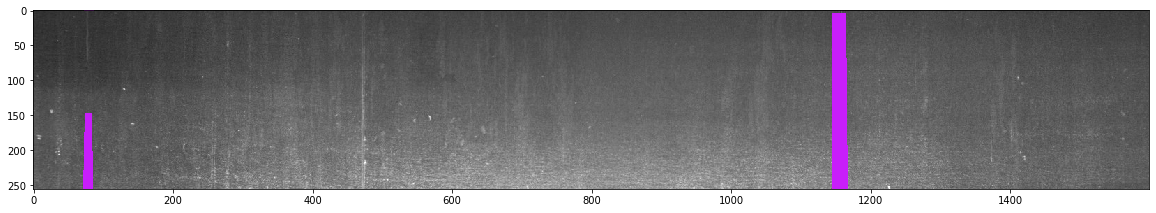

In [16]:
img = cv2.imread(root +'/'+ name)
plt.figure(figsize=(20, 10))
for ch in range(4):
    img[mask[:, :, ch] == 255] = palet[ch]
#     pass
plt.imshow(img)
plt.show()

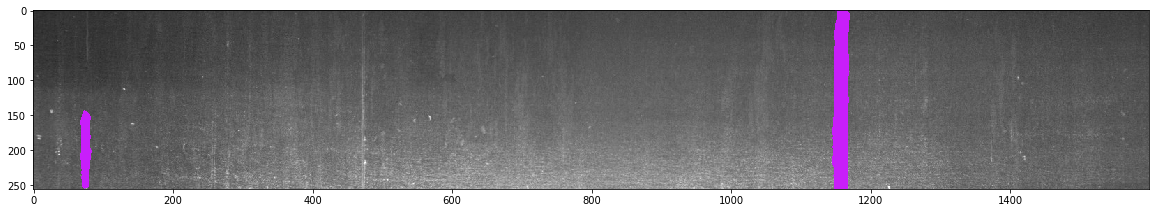

In [17]:
img = cv2.imread(root +'/'+ name)
plt.figure(figsize=(20, 10))
for ch in range(4):
    img[pmask[:, :, ch] == 255] = palet[ch]
    pass
plt.imshow(img)
plt.show()

Let's compute train dice

In [18]:

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)

    with torch.no_grad():

        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos


In [19]:
best_thresholds = 0.1
base_dice_scores, dice_pos_scores, dice_neg_scores = [], [], []
for idx in tqdm(range(len(train_df))):
    name, targets = make_mask(train_df, idx)
    name, probs = make_mask(pred_df, idx)
    targets = torch.Tensor(targets)
    probs = torch.Tensor(probs)
    dice, dice_neg, dice_pos, _, _ = metric(probs, targets, best_thresholds)
    base_dice_scores.append(dice)
    dice_pos_scores.append(dice_pos)
    dice_neg_scores.append(dice_neg)

100%|██████████| 12568/12568 [02:24<00:00, 87.08it/s]


In [20]:
np.mean(base_dice_scores), np.nanmean(dice_pos_scores), np.nanmean(dice_neg_scores)

(0.8508839497941751, 0.33544221406453956, 0.7309450493671754)

In [77]:
predictions = defaultdict()
for i, batch in enumerate(tqdm(testset)):
    if tta:
        # images.shape [n, 3, 96, 96] where n is num of 1+tta
        for fnames, images in batch:
            preds = torch.sigmoid(model(images.to(device)))  # [n, num_classes]
            preds = preds.mean(dim=0).detach().tolist()
            predictions.append(preds)
    else:
        fnames, images = batch
        batch_preds = torch.sigmoid(model(images[:, 0].to(device)))
        batch_preds = batch_preds.detach().cpu().numpy()
        if save_rle:
            for fname, preds in zip(fnames, batch_preds):
                for cls, pred in enumerate(preds):
                    pred, num = post_process(pred, best_threshold, min_size)
                    rle = mask2rle(pred)
                    name = fname + f"_{cls+1}"
                    predictions[name] = rle
        break

  0%|          | 0/3384 [00:00<?, ?it/s]


In [19]:
df.head()

,ImageId_ClassId,EncodedPixels,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg
4,00031f466.jpg_1,NaN,00031f466.jpg


In [18]:
for c, pred in enumerate(preds):
    print(c, pred.max())

0 0.006982712
1 0.0095321555
2 0.9866942
3 0.005579973


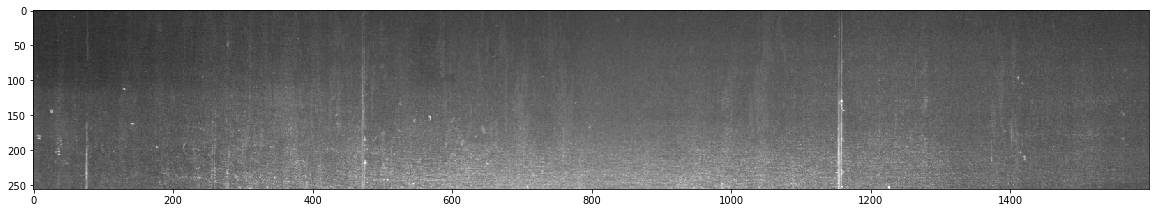

In [32]:
img = cv2.imread(root +'/'+ fname)
plt.figure(figsize=(20, 10))
for ch in range(4):
#     img[mask[:, :, ch] == 255] = palet[ch]
    pass
plt.imshow(img)
plt.show()

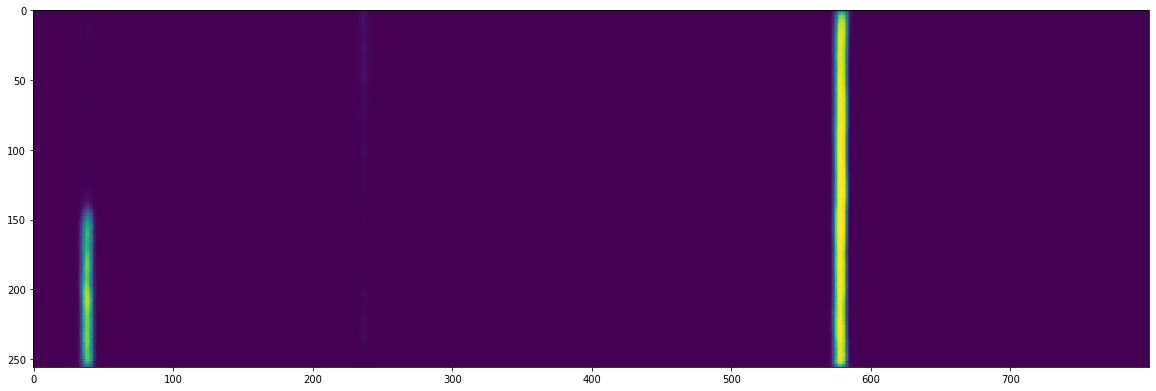

In [79]:
plt.figure(figsize=(20, 10))
plt.imshow(preds[2])

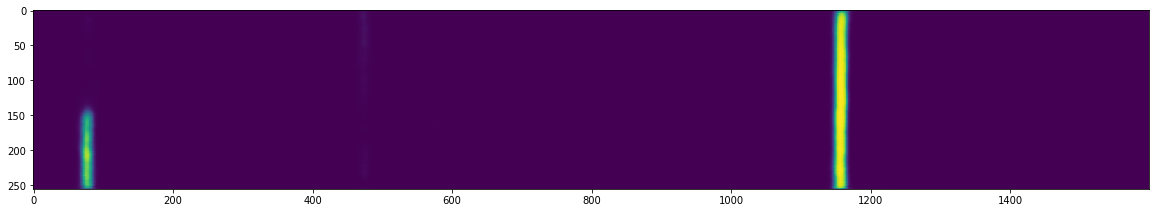

In [80]:

plt.figure(figsize=(20, 10))
rp = cv2.resize(preds[2], (1600, 256))# > 0.1).astype('int')
plt.imshow(rp)

In [82]:
pred, num = post_process(preds[2], best_threshold, min_size)

In [83]:
rp.min(), rp.max() 

(7.12943e-05, 0.9861574)

In [85]:
preds[2].min(), preds[2].max()

(6.899724e-05, 0.9866942)

In [86]:
fname

'0007a71bf.jpg'

In [88]:
rp.shape

(256, 1600)

In [ ]:
metric(torch.Tensor(rp), , best_thresholds)